In [1]:
from model import create_low_level_stage
import os
import glob
import tensorflow as tf
# TODO: Implement dataImportHelper
from dataImportHelper import parse_image_MSR, preprocess_MSR
from customLossesAndMetrics import PSNR_metric

In [2]:
import matplotlib.pyplot as plt

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
#Dataset.list_files

In [5]:
PANASONIC_DATA_PATH ='MSR-Demosaicing/Dataset_LINEAR_with_noise/bayer_panasonic'
DATAX_PATH = os.path.join(os.getcwd(),PANASONIC_DATA_PATH,'input_dem') 
DATAY_PATH = os.path.join(os.getcwd(),PANASONIC_DATA_PATH,'groundtruth') 

In [6]:
#TODO: function that checks images are the same dimension, check parse_image() in dataImportHelper
# Panasonic MSR are all same dimension
H = 132
W = 220
Nll = 20 #Number of low level blocks

In [7]:
ll_model = create_low_level_stage(H,W,Nll)

In [8]:
BATCH_SIZE = 32

## Dataset

In [9]:
ds_dict = {'train':[],'test':[],'validation':[]}
for i in ['train','test','validation']:
    with open(os.path.join(PANASONIC_DATA_PATH,i+'.txt'),'r') as f:
        ds_dict[i] = f.readlines()
        ds_dict[i] = [int(x) for x in ds_dict[i]]

# step 1: Lists of paths to each training data point and ground truth
X_train_paths = tf.constant([os.path.join(DATAX_PATH,xname+'.png') for xname in str(ds_dict['train'])]) 
Y_train_paths = tf.constant([os.path.join(DATAY_PATH,yname+'.png') for yname in str(ds_dict['train'])])
#
X_test_paths = tf.constant([os.path.join(DATAX_PATH,xname+'.png') for xname in str(ds_dict['test'])]) 
Y_test_paths = tf.constant([os.path.join(DATAY_PATH,yname+'.png') for yname in str(ds_dict['test'])])
#
X_val_paths = tf.constant([os.path.join(DATAX_PATH,xname+'.png') for xname in str(ds_dict['validation'])]) 
Y_val_paths = tf.constant([os.path.join(DATAY_PATH,yname+'.png') for yname in str(ds_dict['validation'])])

In [10]:
########### Training set ##########
list_ds_train_X = tf.data.Dataset.list_files(X_train_paths, seed=42) # seed for random but consistent shuffling #TODO: vs ds.shuffle(buffer)  ??
list_ds_train_Y = tf.data.Dataset.list_files(Y_train_paths, seed=42)

trainX = list_ds_train_X.map(parse_image_MSR)  #TODO: .map(preprocess_MSR)
trainY = list_ds_train_Y.map(parse_image_MSR)

ds_train = tf.data.Dataset.zip((trainX,trainY)).batch(BATCH_SIZE)
########## Test set ##########
list_ds_test_X = tf.data.Dataset.list_files(X_test_paths, seed=42) # seed for random but consistent shuffling #TODO: vs ds.shuffle(buffer)  ??
list_ds_test_Y = tf.data.Dataset.list_files(Y_test_paths, seed=42)

testX = list_ds_test_X.map(parse_image_MSR)
testY = list_ds_test_Y.map(parse_image_MSR)

ds_test = tf.data.Dataset.zip((testX,testY)).batch(BATCH_SIZE)
########## Validation set ##########
list_ds_val_X = tf.data.Dataset.list_files(X_val_paths, seed=42) # seed for random but consistent shuffling #TODO: vs ds.shuffle(buffer)  ??
list_ds_val_Y = tf.data.Dataset.list_files(Y_val_paths, seed=42)

valX = list_ds_val_X.map(parse_image_MSR)
valY = list_ds_val_Y.map(parse_image_MSR)

ds_val = tf.data.Dataset.zip((valX,valY)).batch(BATCH_SIZE)


## Training

In [11]:
## Dir to save model progress
checkpoint_path = "training_DD_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [12]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-08)

In [14]:
ll_model.compile(optimizer=optimizer,  # Optimizer
              # Loss function to minimize
              loss=tf.keras.losses.MeanSquaredError(),
              # List of metrics to monitor
              metrics=[PSNR_metric])

In [15]:
history =  ll_model.fit(x= ds_train,   
              epochs=5000,
              validation_data=ds_val,
              validation_freq=25,
              validation_steps=None, #use all val dataset
              verbose=1,
              callbacks=[cp_callback])  # Pass callback to training

Epoch 1/5000
     16/Unknown - 40s 2s/step - loss: 1.5849 - PSNR_metric: -1.8690
Epoch 00001: saving model to training_DD_1/cp.ckpt
16/16 [==============================] - 40s 2s/step - loss: 1.5849 - PSNR_metric: -1.8690
Epoch 2/5000
15/16 [===========================>..] - ETA: 2s - loss: 1.4293 - PSNR_metric: -1.3924
Epoch 00002: saving model to training_DD_1/cp.ckpt
16/16 [==============================] - 39s 2s/step - loss: 1.4290 - PSNR_metric: -1.3748
Epoch 3/5000
15/16 [===========================>..] - ETA: 2s - loss: 1.2713 - PSNR_metric: -0.8710
Epoch 00003: saving model to training_DD_1/cp.ckpt
16/16 [==============================] - 38s 2s/step - loss: 1.2713 - PSNR_metric: -0.8712
Epoch 4/5000
15/16 [===========================>..] - ETA: 2s - loss: 1.1385 - PSNR_metric: -0.3715
Epoch 00004: saving model to training_DD_1/cp.ckpt
16/16 [==============================] - 38s 2s/step - loss: 1.1381 - PSNR_metric: -0.3497
Epoch 5/5000
15/16 [===========================>..]

KeyboardInterrupt: 

In [17]:
predictions = ll_model.predict(ds_test)

In [24]:
predictions[0].shape

(132, 220, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


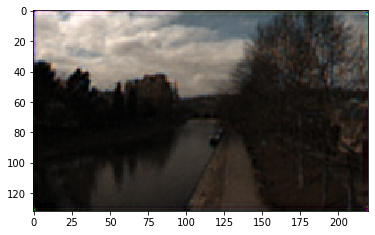

In [26]:
plt.imshow(predictions[1])